<a href="https://colab.research.google.com/github/lilacs2039/ColabNotebooks/blob/master/fastai/fastai_CIFAR10_simpleCNN_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

In [3]:
!curl https://course-v3.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   287  100   287    0     0    243      0  0:00:01  0:00:01 --:--:--   243
bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">'


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from torchsummary import summary


In [0]:
bs = 64
sz = 32
tfms = get_transforms(max_rotate=25)

np.random.seed(2)

# ここから開始

データセットは↓からCIFAR10を選択  

https://course.fast.ai/datasets


# Training: SimpleCNN

In [7]:
path = untar_data(URLs.CIFAR); path

PosixPath('/root/.fastai/data/cifar10')

In [8]:
path.ls()

[PosixPath('/root/.fastai/data/cifar10/test'),
 PosixPath('/root/.fastai/data/cifar10/labels.txt'),
 PosixPath('/root/.fastai/data/cifar10/train')]

In [0]:
path_train = path/'train'
path_test = path/'test'

In [10]:
path_train.ls()[0:4]

[PosixPath('/root/.fastai/data/cifar10/train/automobile'),
 PosixPath('/root/.fastai/data/cifar10/train/ship'),
 PosixPath('/root/.fastai/data/cifar10/train/deer'),
 PosixPath('/root/.fastai/data/cifar10/train/dog')]

In [11]:
path_test.ls()[0:4]

[PosixPath('/root/.fastai/data/cifar10/test/automobile'),
 PosixPath('/root/.fastai/data/cifar10/test/ship'),
 PosixPath('/root/.fastai/data/cifar10/test/deer'),
 PosixPath('/root/.fastai/data/cifar10/test/dog')]

In [12]:
(path_train/'automobile').ls()[0:4]

[PosixPath('/root/.fastai/data/cifar10/train/automobile/9189_automobile.png'),
 PosixPath('/root/.fastai/data/cifar10/train/automobile/15855_automobile.png'),
 PosixPath('/root/.fastai/data/cifar10/train/automobile/22658_automobile.png'),
 PosixPath('/root/.fastai/data/cifar10/train/automobile/34723_automobile.png')]

In [13]:
(path_test/'automobile').ls()[0:4]

[PosixPath('/root/.fastai/data/cifar10/test/automobile/5378_automobile.png'),
 PosixPath('/root/.fastai/data/cifar10/test/automobile/3645_automobile.png'),
 PosixPath('/root/.fastai/data/cifar10/test/automobile/6580_automobile.png'),
 PosixPath('/root/.fastai/data/cifar10/test/automobile/7005_automobile.png')]

In [14]:
!head '/root/.fastai/data/cifar10/labels.txt'

airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck


## DataBunch　作成
ファイル構成が以下のようになっていることが分かったので、DataBunchを作成する。
labels.txtは単なるラベルの列挙なので使用しない。


```
cifar10/
　├ train/
　│  ├ automobile/    <- クラス名
    │  │  ├ 9189_automobile.png
    │  │  ├ 15855_automobile.png
    │  │
    │ 
　└ test/
　        ├ automobile/    <- クラス名
            │  ├ 5378_automobile.png
            │  ├ 3645_automobile.png
            │
 
 ```
 

In [0]:
data = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_folder(valid="test")              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=sz)       #Data augmentation? -> use tfms with a size of 64
        .databunch(bs=bs))                   #Finally? -> use the defaults for conversion to ImageDataBunch
# data = ImageDataBunch.from_folder(path)


In [30]:
data

ImageDataBunch;

Train: LabelList (50000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
automobile,automobile,automobile,automobile,automobile
Path: /root/.fastai/data/cifar10;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
automobile,automobile,automobile,automobile,automobile
Path: /root/.fastai/data/cifar10;

Test: LabelList (10000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: EmptyLabelList
,,,,
Path: /root/.fastai/data/cifar10

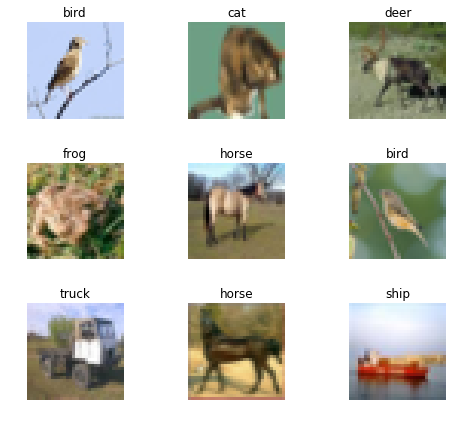

In [22]:
data.show_batch(rows=3, figsize=(7,6))

In [23]:
print(data.classes)
len(data.classes),data.c

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


(10, 10)

In [0]:
# 参考　https://github.com/arunkashyap294/fastai/blob/7b1a1684d4870761f97906f027b00a7dc54121a0/docs_src/callbacks.mixup.ipynb
model = simple_cnn((3,16,16,10))
learn = Learner(data, model, metrics=[accuracy])

In [27]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (2): Sequential(
    (0): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (3): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten()
  )
)

In [37]:
# kerasのようなモデルのサマリー　by torchsummary 
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
              ReLU-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 16, 8, 8]           2,320
              ReLU-4             [-1, 16, 8, 8]               0
            Conv2d-5             [-1, 10, 4, 4]           1,450
              ReLU-6             [-1, 10, 4, 4]               0
 AdaptiveAvgPool2d-7             [-1, 10, 1, 1]               0
           Flatten-8                   [-1, 10]               0
Total params: 4,218
Trainable params: 4,218
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.02
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


In [0]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.951029,1.896422,0.311600,00:58
1,1.762488,1.671042,0.397900,00:58
2,1.658369,1.587707,0.425000,00:58
3,1.630139,1.579989,0.426300,00:57


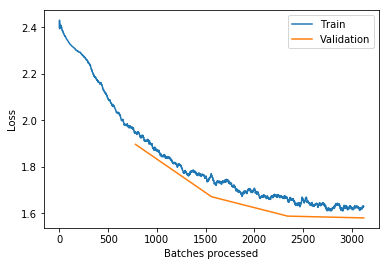

In [33]:
learn.recorder.plot_losses()

# Training : ResBlock
参考　https://github.com/SESCDS/sescds/blob/7309b40cc4948d21a57e585d5e75fa1f26490956/Part%202/Lesson%206/Lesson6.ipynb

In [0]:
# model = simple_cnn((3,16,16,10))
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)
model = nn.Sequential(
    conv2(3, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)
learn = Learner(data, model, metrics=[accuracy])

In [41]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 16, 16]             216
              ReLU-2            [-1, 8, 16, 16]               0
       BatchNorm2d-3            [-1, 8, 16, 16]              16
            Conv2d-4            [-1, 8, 16, 16]             576
              ReLU-5            [-1, 8, 16, 16]               0
       BatchNorm2d-6            [-1, 8, 16, 16]              16
            Conv2d-7            [-1, 8, 16, 16]             576
              ReLU-8            [-1, 8, 16, 16]               0
       BatchNorm2d-9            [-1, 8, 16, 16]              16
       MergeLayer-10            [-1, 8, 16, 16]               0
     SequentialEx-11            [-1, 8, 16, 16]               0
           Conv2d-12             [-1, 16, 8, 8]           1,152
             ReLU-13             [-1, 16, 8, 8]               0
      BatchNorm2d-14             [-1, 1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


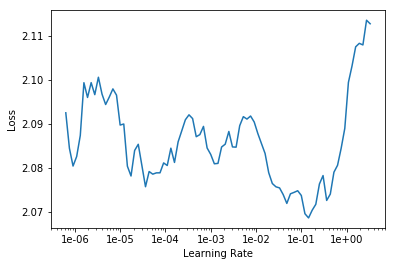

In [44]:
learn.lr_find()
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.700452,1.622021,0.425200,01:07
1,1.452037,1.336483,0.520400,01:06
2,1.277777,1.185367,0.584300,01:07
3,1.241277,1.121613,0.607000,01:07


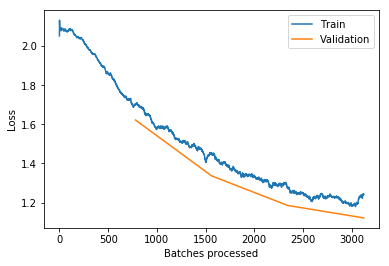

In [46]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


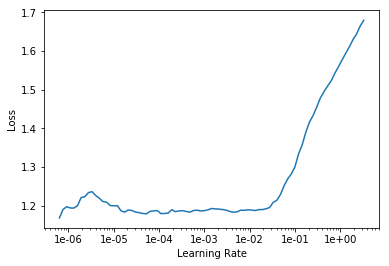

In [47]:
learn.lr_find()
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(50,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.185223,1.095098,0.618700,01:12
1,1.174050,1.081264,0.620500,01:12
2,1.196716,1.080886,0.617600,01:12
3,1.190679,1.080400,0.619400,01:12
4,1.162768,1.060626,0.626500,01:10
5,1.174680,1.141227,0.601600,01:11
6,1.159352,1.100258,0.611800,01:11
7,1.095946,1.198122,0.592700,01:10
8,1.122290,1.049741,0.634100,01:10
9,1.083378,1.058962,0.621100,01:11


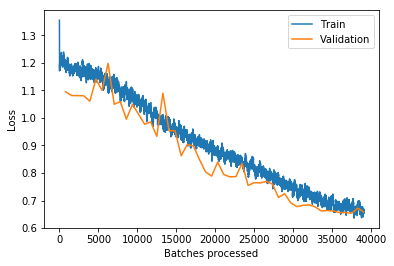

In [50]:
learn.recorder.plot_losses()